In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import statsmodels.api as sm

In [2]:
pubs_author_funder = pd.read_csv("..//..//data//dropbox//Data//DerivedData//CleanedRawData//pubs_author_funder.csv")
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(
    lambda x: literal_eval(x) if pd.notnull(x) else "Not-Funded")
#pubs_author_funder['funding_units'] = pubs_author_funder['funder_country'].apply(lambda x: len(x))
pubs_author_funder.head()

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],77,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9
2,30574691,[Russia],[Russia],83,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3


### calculate the ratio of funded paper every year

In [3]:
pubs_author_funder['funded']=pubs_author_funder['funder_country'].apply(
    lambda x:1 if x!='Not-Funded' else 0)
pubs_author_funder['IntCol']=pubs_author_funder['author_country'].apply(
    lambda x:1 if len(set(x))>1 else 0)
pubs_author_funder

,id,author_country,funder_country,discipline,year,rel_citation,citation,funded,IntCol
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,1,0
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,1,1
2,30574691,[Russia],[Russia],83,2009,0.312,4,1,0
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,1,0
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3,1,1
...,...,...,...,...,...,...,...,...,...
12759123,65301180,[Pakistan],Not-Funded,89,2018,0.000,0,0,0
12759124,65301286,"[Singapore, Singapore]",Not-Funded,44,2017,0.264,1,0,0
12759125,65301288,[Iran],Not-Funded,96,2017,0.000,0,0,0
12759126,65301295,[Israel],Not-Funded,96,2017,0.000,0,0,0


In [56]:
def CalFundRatio(pub_data, all='ALL'):
    if all !='ALL':
        data=pub_data[pub_data.IntCol==all]
    else:
        data=pub_data
    year_fund=data.groupby(['year','funded']).size()
    year_fund = year_fund.reset_index()
    year_fund.columns=['year','funded','count']
    year_fund=year_fund.pivot(index='year',columns='funded',values='count')
    year_fund = year_fund.rename({0:'not-funded',1:'funded'},axis=1)
    year_fund['total']=year_fund.sum(axis=1)
    print(year_fund.columns)
    year_fund['fund_ratio']=year_fund['funded']/year_fund['total']
    year_fund=year_fund.reset_index()
    return year_fund

In [62]:
r = CalFundRatio(pubs_author_funder)
r

Index(['not-funded', 'funded', 'total'], dtype='object', name='funded')


funded,year,not-funded,funded,total,fund_ratio
0,2009,544610,497514,1042124,0.477404
1,2010,485759,592204,1077963,0.549373
2,2011,473446,672988,1146434,0.587027
3,2012,484497,725576,1210073,0.599613
4,2013,496478,781347,1277825,0.611466
5,2014,499154,818388,1317542,0.621148
6,2015,495441,864558,1359999,0.635705
7,2016,518369,884993,1403362,0.630623
8,2017,495331,920898,1416229,0.650247
9,2018,526261,981316,1507577,0.650923


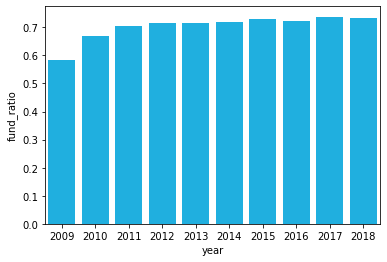

In [54]:
sns.barplot(x='year',y='fund_ratio',data=r,color='deepskyblue')
plt.savefig("fundratio.png",format='png')

In [12]:
cntry_fund_frac = []
for index, row in pubs_author_funder.iterrows():
    year=row['year']
    funded=row['funded']
    coll=row['IntCol']
    funder_cntrys=row['funder_country']
    if funder_cntrys=='Not-Funded':
        cntry_fund_frac.append([funder_cntrys,1,year,funded,coll])
    else:
        funder_cntrys=list(set(funder_cntrys))
        n=len(funder_cntrys)
        for c in funder_cntrys:
            cntry_fund_frac.append([c,1/n,year,funded,coll])

In [25]:
cntry_fund_frac_df = pd.DataFrame(cntry_fund_frac,
                                  columns=['fund_cntry','cnt_frac','year','funded','intcol'])

In [26]:
cntry_fund_frac_df = cntry_fund_frac_df.groupby(['year','fund_cntry'])['cnt_frac'].sum().reset_index(name='count')
cntry_fund_frac_df=cntry_fund_frac_df.pivot_table(index='year',columns='fund_cntry',values='count',fill_value=0)
cntry_fund_frac_df.head()

fund_cntry,Afghanistan,Albania,Algeria,Andorra,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
year,,,,,,,,,,,,,,,,,,,,,
2009,0.000000,0.000000,83.283333,2.000000,0.500000,2702.798107,43.924242,10509.063709,2121.680754,1.333333,...,128274.794270,118.392857,26.333333,2.5,0.142857,195.916667,126.166667,9.500000,4.000000,7.833333
2010,1.000000,2.000000,110.983333,0.666667,2.000000,3199.773442,54.145809,12518.676628,2468.632653,7.755999,...,149016.176263,131.622222,34.862037,0.0,0.142857,189.176190,229.166667,13.333333,5.666667,11.583333
2011,0.333333,1.666667,138.500000,0.333333,3.333333,3553.770082,54.546890,14412.646531,2891.836897,27.398084,...,162396.956217,174.492857,31.752828,0.0,0.000000,170.559524,376.642157,14.833333,8.333333,10.233333
2012,0.333333,1.666667,147.083333,1.000000,3.000000,3782.213814,67.740256,15324.368864,2948.853110,32.986351,...,166608.039460,153.650000,29.208037,1.0,0.000000,138.851190,514.585913,27.833333,4.750000,12.166667
2013,0.000000,1.500000,187.916667,4.583333,3.000000,3765.715915,64.908553,16927.247091,3260.240720,30.089387,...,170441.840422,191.643590,25.848185,0.5,0.000000,138.750000,633.192647,12.500000,7.533333,25.583333


In [30]:
pubs_author_funder.groupby('year').size()

year
2009    1042124
2010    1077963
2011    1146434
2012    1210073
2013    1277825
2014    1317542
2015    1359999
2016    1403362
2017    1416229
2018    1507577
dtype: int64

In [28]:
cntry_fund_frac_df.sum(axis=1)

year
2009    1042124.0
2010    1077963.0
2011    1146434.0
2012    1210073.0
2013    1277825.0
2014    1317542.0
2015    1359999.0
2016    1403362.0
2017    1416229.0
2018    1507577.0
dtype: float64

### count the ratio of papers that have funding from specific country

In [74]:
def get_cntry_fund(pub_data):
    data=pub_data.copy()
    data['funder_country']=data['funder_country'].apply(
    lambda x:list(set(x)) if x!='Not-Funded' else x)
    fund_df=data.explode('funder_country')
    cntry_fund=fund_df.groupby(['funder_country','year']).size().reset_index()
    cntry_fund.columns=['funder_country','year','count']
    cntry_fund=cntry_fund.pivot(index='funder_country',columns='year',values='count')
    cntry_fund=cntry_fund.fillna(0)
    return cntry_fund

In [45]:
def get_year_total(data,yearlist):
    numyear_df = data.groupby('year').size().reindex(yearlist).reset_index()
    numyear_df.columns=['year','count']
    return numyear_df

In [46]:
def cal_percent(cntry_df, year_df, yearlist, n):
    cntry_ratio = cntry_df[yearlist].divide(year_df['count'].values,axis=1)
    topn = cntry_ratio.sort_values(by=2018,ascending=False).head(n).reset_index()
    topn = topn.melt(id_vars='funder_country',var_name='year',value_name='percent')
    topn = topn.query('funder_country!="Not-Funded"')
    return topn

In [75]:
year_total

,year,count
0,2009,1042124
1,2010,1077963
2,2011,1146434
3,2012,1210073
4,2013,1277825
5,2014,1317542
6,2015,1359999
7,2016,1403362
8,2017,1416229
9,2018,1507577


In [47]:
yearlist=np.arange(2009,2019)
fund_df=pubs_author_funder[['id','funder_country','year']]
cntry_fund=get_cntry_fund(fund_df)
year_total=get_year_total(pubs_author_funder,yearlist)
top10=cal_percent(cntry_fund,year_total,yearlist,11)

<ipython-input-44-8fd48151079d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['funder_country']=data['funder_country'].apply(


In [49]:
top10

,funder_country,year,percent
1,China,2009,0.077223
2,United States,2009,0.140296
3,EU,2009,0.022353
4,United Kingdom,2009,0.027102
5,Germany,2009,0.028054
...,...,...,...
105,Japan,2018,0.029587
106,South Korea,2018,0.026712
107,Canada,2018,0.021161
108,Brazil,2018,0.020890


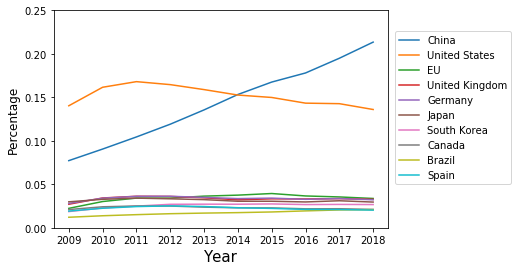

In [50]:
sns.lineplot(data=top10,x='year',y='percent',hue='funder_country')
plt.legend(loc=[1.02,0.2])
plt.xlabel('Year',fontsize=15)
plt.xticks(yearlist)
plt.ylabel('Percentage',fontsize=12)
plt.ylim(0,0.25)
plt.savefig("percentage_all.png",bbox_inches='tight')

In [70]:
pubs_author_funder

,id,author_country,funder_country,discipline,year,rel_citation,citation,funded,IntCol
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,1,0
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,1,1
2,30574691,[Russia],[Russia],83,2009,0.312,4,1,0
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,1,0
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3,1,1
...,...,...,...,...,...,...,...,...,...
12759123,65301180,[Pakistan],Not-Funded,89,2018,0.000,0,0,0
12759124,65301286,"[Singapore, Singapore]",Not-Funded,44,2017,0.264,1,0,0
12759125,65301288,[Iran],Not-Funded,96,2017,0.000,0,0,0
12759126,65301295,[Israel],Not-Funded,96,2017,0.000,0,0,0


Index(['not-funded', 'funded', 'total'], dtype='object', name='funded')
Index(['not-funded', 'funded', 'total'], dtype='object', name='funded')
Index(['not-funded', 'funded', 'total'], dtype='object', name='funded')


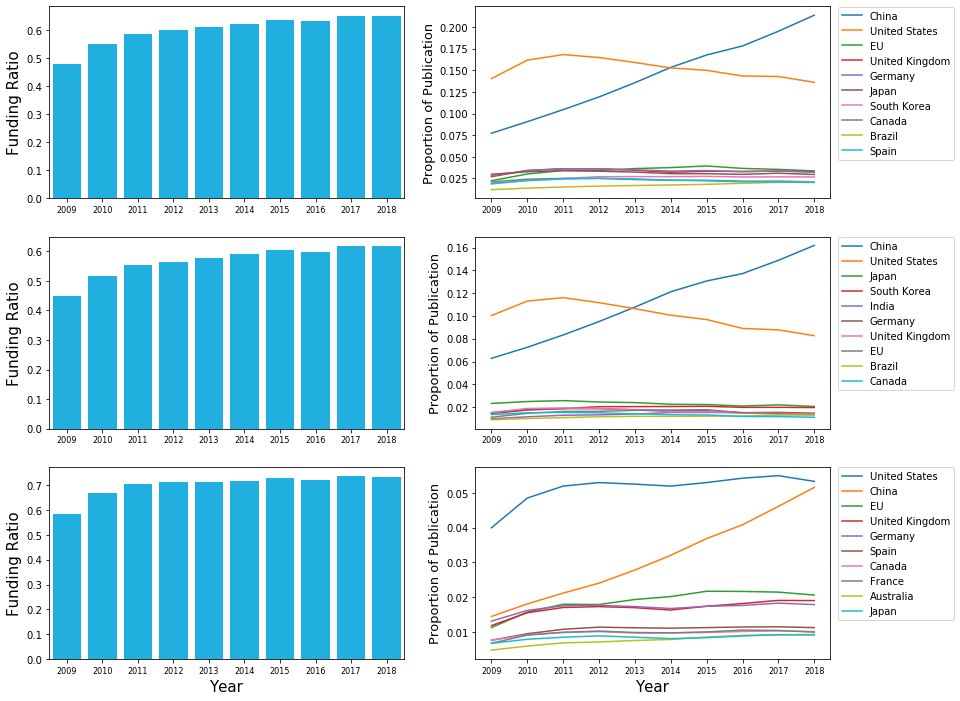

In [86]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(14,12))
plt.matplotlib.rc('xtick', labelsize=9) 

ratio_all = CalFundRatio(pubs_author_funder)
sns.barplot(x='year',y='fund_ratio',data=ratio_all,color='deepskyblue',ax=axes[0,0])
axes[0,0].set_xlabel("")
axes[0,0].set_ylabel("Funding Ratio",fontsize=15)

ratio_notcol = CalFundRatio(pubs_author_funder,all=0)
sns.barplot(x='year',y='fund_ratio',data=ratio_notcol,color='deepskyblue',ax=axes[1,0])
axes[1,0].set_xlabel("")
axes[1,0].set_ylabel("Funding Ratio",fontsize=15)


ratio_col = CalFundRatio(pubs_author_funder,all=1)
sns.barplot(x='year',y='fund_ratio',data=ratio_col,color='deepskyblue',ax=axes[2,0])
axes[2,0].set_xlabel("Year",fontsize=15)
axes[2,0].set_ylabel("Funding Ratio",fontsize=15)


yearlist=np.arange(2009,2019)
fund_df=pubs_author_funder[['id','funder_country','year']]
cntry_fund=get_cntry_fund(fund_df)
year_total=get_year_total(pubs_author_funder,yearlist)
top10=cal_percent(cntry_fund,year_total,yearlist,11)
sns.lineplot(data=top10,x='year',y='percent',hue='funder_country',ax=axes[0,1])
axes[0,1].legend(loc=[1.02,0.2])
axes[0,1].set_xticks(ticks=yearlist)
axes[0,1].set_xlabel("")
axes[0,1].set_ylabel("Proportion of Publication",fontsize=13)


yearlist=np.arange(2009,2019)
fund_df=pubs_author_funder[['id','funder_country','year','IntCol']]
fund_df=fund_df[fund_df.IntCol==0]
cntry_fund=get_cntry_fund(fund_df)
year_total=get_year_total(pubs_author_funder,yearlist)
top10=cal_percent(cntry_fund,year_total,yearlist,11)
sns.lineplot(data=top10,x='year',y='percent',hue='funder_country',ax=axes[1,1])
axes[1,1].legend(loc=[1.02,0.2])
axes[1,1].set_xticks(ticks=yearlist)
axes[1,1].set_xlabel("")
axes[1,1].set_ylabel("Proportion of Publication",fontsize=13)


yearlist=np.arange(2009,2019)
fund_df=pubs_author_funder[['id','funder_country','year','IntCol']]
fund_df=fund_df[fund_df.IntCol==1]
cntry_fund=get_cntry_fund(fund_df)
year_total=get_year_total(pubs_author_funder,yearlist)
top10=cal_percent(cntry_fund,year_total,yearlist,11)
sns.lineplot(data=top10,x='year',y='percent',hue='funder_country',ax=axes[2,1])
axes[2,1].legend(loc=[1.02,0.2])
axes[2,1].set_xticks(ticks=yearlist)
axes[2,1].set_xlabel("Year",fontsize=15)
axes[2,1].set_ylabel("Proportion of Publication",fontsize=13)
plt.savefig("funding_ratio.pdf",bbox_inches="tight")

### measure countries contribution to global science.
### global science is defined as coauthor,cofund,coauthor&cofund,single author with foreign fund

In [80]:
pubs_author_funder.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation,funded,global
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,1,0
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,1,1
2,30574691,[Russia],[Russia],83,2009,0.312,4,1,0
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,1,0
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3,1,1


In [7]:
def GlobalScience(authorlist,funderlist):
    authorlist=list(set(authorlist))
    if (funderlist=='Not-Funded'):
        if (len(authorlist)==1):
            return 0
        else:
            return 1
    else:
        funderlist=list(set(funderlist))
        if (len(authorlist)==1)&(len(funderlist)==1)&(authorlist[0]==funderlist[0]):
            return 0
        else:
            return 1
pubs_author_funder['global']=pubs_author_funder[['author_country','funder_country']].apply(
lambda x:GlobalScience(x['author_country'],x['funder_country']),axis=1)

In [81]:
gscience_df=pubs_author_funder[['id','funder_country','year','global']]
gscience_df=gscience_df[gscience_df['global']==1]
cntry_gscience_fund=get_cntry_fund(gscience_df)
gscience_year_total=get_year_total(gscience_df,yearlist)
top10=cal_percent(cntry_gscience_fund,gscience_year_total,yearlist,11)

In [84]:
top10.sort_values(by='percent',ascending=False)

,funder_country,year,percent
23,United States,2011,0.255073
34,United States,2012,0.252954
12,United States,2010,0.244618
45,United States,2013,0.240390
56,United States,2014,0.227939
...,...,...,...
54,Australia,2013,0.032583
43,Australia,2012,0.032423
32,Australia,2011,0.032283
21,Australia,2010,0.029839


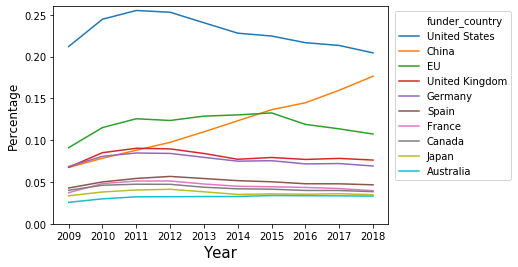

In [86]:
sns.lineplot(data=top10,x='year',y='percent',hue='funder_country')
plt.legend(loc=[1.02,0.2])
plt.xlabel('Year',fontsize=15)
plt.xticks(yearlist)
plt.ylabel('Percentage',fontsize=12)
plt.ylim(0,0.26)
plt.savefig("percentage_globalscience.png",bbox_inches='tight')

In [14]:
homescience.sum(axis=1)

year
2009    1042124
2010    1077963
2011    1146434
2012    1210073
2013    1277825
2014    1317542
2015    1359999
2016    1403362
2017    1416229
2018    1507577
dtype: int64

In [18]:
homescience = pubs_author_funder.groupby(['year','global']).size().rename('count').reset_index()
homescience=homescience.pivot(index='year',columns='global',values='count')
homescience.columns=['home','coll']
homescience=homescience.div(homescience.sum(axis=1),axis=0)
homescience=homescience.reset_index()

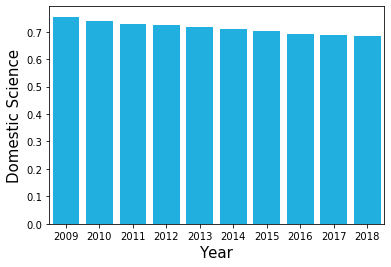

In [21]:
sns.barplot(x='year',y='home',data=homescience,color='deepskyblue')
plt.xlabel("Year",fontsize=15)
plt.ylabel("Domestic Science",fontsize=15)
plt.savefig("domestic-science.png",format='png')

In [25]:
pubs_author_funder['author_distinct']=pubs_author_funder['author_country'].apply(
    lambda x:list(set(x)))
pubs_author_funder['funder_distinct']=pubs_author_funder['funder_country'].apply(
    lambda x:list(set(x)) if x!='Not-Funded' else "Not-Funded")

In [26]:
homescience = pubs_author_funder[pubs_author_funder['global']==0]
homescience

,id,author_country,funder_country,discipline,year,rel_citation,citation,funded,global,author_distinct,funder_distinct
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,1,0,[Turkey],[Turkey]
2,30574691,[Russia],[Russia],83,2009,0.312,4,1,0,[Russia],[Russia]
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,1,0,[Spain],[Spain]
5,30585101,[United States],[United States],89,2009,1.230,9,1,0,[United States],[United States]
6,30585102,[United States],[United States],89,2009,0.137,1,1,0,[United States],[United States]
...,...,...,...,...,...,...,...,...,...,...,...
12759123,65301180,[Pakistan],Not-Funded,89,2018,0.000,0,0,0,[Pakistan],Not-Funded
12759124,65301286,"[Singapore, Singapore]",Not-Funded,44,2017,0.264,1,0,0,[Singapore],Not-Funded
12759125,65301288,[Iran],Not-Funded,96,2017,0.000,0,0,0,[Iran],Not-Funded
12759126,65301295,[Israel],Not-Funded,96,2017,0.000,0,0,0,[Israel],Not-Funded


In [58]:
cntry_home=homescience.explode('author_distinct')
cntry_home = cntry_home.groupby(['year','author_distinct']).size().rename('count').reset_index()
cntry_home.head()

,year,author_distinct,count
0,2009,Afghanistan,1
1,2009,Albania,21
2,2009,Algeria,598
3,2009,Andorra,1
4,2009,Angola,1


In [59]:
cntry_home = cntry_home.pivot(index='author_distinct',columns='year',values='count').sort_values(by=2018,ascending=False)
cntry_home.head()

year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
author_distinct,,,,,,,,,,
China,93852.0,101524.0,118502.0,138710.0,162862.0,187295.0,208258.0,225389.0,243355.0,282639.0
United States,185691.0,184540.0,187508.0,190603.0,193347.0,191552.0,187809.0,183688.0,178861.0,182105.0
India,30719.0,32685.0,35525.0,37547.0,41103.0,44299.0,45613.0,46985.0,48159.0,51167.0
Japan,55119.0,53363.0,54002.0,53558.0,54290.0,52730.0,50811.0,50288.0,49982.0,50491.0
South Korea,26357.0,28501.0,30651.0,33208.0,34354.0,36199.0,37858.0,38113.0,37304.0,39273.0


In [42]:
cntry_home = cntry_home.div(cntry_home.sum(),axis=1)
cntry_home.head()

year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
author_distinct,,,,,,,,,,
China,0.119352,0.127691,0.141950,0.158403,0.177706,0.199776,0.217905,0.232076,0.249938,0.273385
United States,0.236144,0.232103,0.224611,0.217663,0.210969,0.204317,0.196509,0.189138,0.183700,0.176143
India,0.039066,0.041109,0.042554,0.042878,0.044849,0.047251,0.047726,0.048379,0.049462,0.049492
Japan,0.070095,0.067117,0.064688,0.061162,0.059238,0.056244,0.053165,0.051780,0.051334,0.048838
South Korea,0.033518,0.035847,0.036716,0.037923,0.037485,0.038611,0.039612,0.039244,0.038313,0.037987


In [52]:
top10=cntry_home.head(10).reset_index()
top10

year,author_distinct,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,China,0.119352,0.127691,0.141950,0.158403,0.177706,0.199776,0.217905,0.232076,0.249938,0.273385
1,United States,0.236144,0.232103,0.224611,0.217663,0.210969,0.204317,0.196509,0.189138,0.183700,0.176143
2,India,0.039066,0.041109,0.042554,0.042878,0.044849,0.047251,0.047726,0.048379,0.049462,0.049492
3,Japan,0.070095,0.067117,0.064688,0.061162,0.059238,0.056244,0.053165,0.051780,0.051334,0.048838
4,South Korea,0.033518,0.035847,0.036716,0.037923,0.037485,0.038611,0.039612,0.039244,0.038313,0.037987
5,Germany,0.048152,0.046623,0.045233,0.044387,0.042236,0.039856,0.038541,0.036852,0.036125,0.034228
6,Brazil,0.026669,0.027336,0.027636,0.027553,0.027322,0.026569,0.026233,0.026622,0.027440,0.027607
7,Italy,0.032910,0.031472,0.030464,0.030489,0.030889,0.029643,0.028537,0.028229,0.027021,0.026288
8,Iran,0.014351,0.016737,0.020123,0.021784,0.021351,0.022004,0.023184,0.025449,0.026652,0.026275
9,United Kingdom,0.040950,0.039452,0.036589,0.035333,0.033326,0.030816,0.029564,0.028408,0.026629,0.025544


In [53]:
top10 = top10.melt(id_vars='author_distinct',var_name='year',value_name='percent')
top10.head()

,author_distinct,year,percent
0,China,2009,0.119352
1,United States,2009,0.236144
2,India,2009,0.039066
3,Japan,2009,0.070095
4,South Korea,2009,0.033518


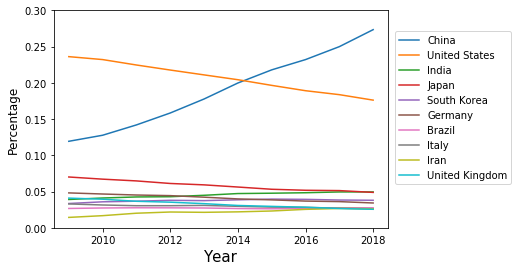

In [57]:
sns.lineplot(data=top10,x='year',y='percent',hue='author_distinct')
plt.legend(loc=[1.02,0.2])
plt.xlabel('Year',fontsize=15)
#plt.xticks(yearlist)
plt.ylabel('Percentage',fontsize=12)
plt.ylim(0,0.30)
plt.savefig("percentage_internalscience.png",bbox_inches='tight')

In [3]:
cntry_cntry_dis_df=pd.read_csv("..//..//..//data//Data//DerivedData//Derived//funding_source_target_dis.csv")
cntry_cntry_dis_df.head()

,source,target,year,discipline,unit
0,Afghanistan,Afghanistan,2010,66,0.500000
1,Afghanistan,Australia,2018,69,0.333333
2,Afghanistan,Bangladesh,2011,47,0.666667
3,Afghanistan,Bolivia,2016,71,0.125000
4,Afghanistan,Canada,2015,71,0.333333


In [11]:
source_df=cntry_cntry_dis_df.groupby(['source','year'])['unit'].sum().reset_index()
source_df = source_df.pivot(index="source",columns='year',values='unit')
source_df=source_df.fillna(0)
source_df['increase']=source_df[2018]-source_df[2009]
source_df = source_df.sort_values(by='increase',ascending=False)
source_df.head()

year,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,increase
source,,,,,,,,,,,
China,207797.0,269686.0,350534.0,444263.0,560363.0,669299.0,765902.0,848391.0,943953.0,1115653.0,907856.0
United States,330079.0,421786.0,486212.0,518570.0,522958.0,515540.0,533676.0,535317.0,542634.0,556185.0,226106.0
United Kingdom,44361.0,61443.0,71757.0,77961.0,80191.0,78784.0,87376.0,92659.0,96295.0,102333.0,57972.0
Brazil,27234.0,32988.0,39500.0,46383.0,51927.0,56674.0,61445.0,68552.0,73665.0,81881.0,54647.0
Japan,56834.0,66701.0,75781.0,79825.0,84102.0,84046.0,89674.0,94756.0,104290.0,109906.0,53072.0
